<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# German News Articles - Data inspection and baseline

Reto Steiner


## Links
- [Ten Thousand German News Articles Dataset](https://tblock.github.io/10kGNAD/)

In [1]:
#%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'
!pip install transformers
from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe
import pandas as pd
import numpy as np
import re
import tqdm
from datetime import datetime
from transformers import AutoTokenizer, TFAutoModel
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import re
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
tqdm.tqdm.pandas()
sns.set_style('whitegrid')

pd.options.display.max_colwidth = 600
pd.options.display.max_rows = 400


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.7 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=8f28a92f2c5cd1c4465bbb189c9d155a4c928b39057abe66d6b84fd1f27e8289
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 121.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.9 MB/s eta 0:00:00


In [2]:
file = "data/german_news_articles_original_train.parq"
download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
data_train = load_dataframe(file)

file = "data/german_news_articles_original_test.parq"
download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
data_test = load_dataframe(file)

In [3]:
def clean_text(text, keep_punctuation=False):
    """Cleans text by removing html tags, non ascii chars, digits and optionally punctuation"""



    # Compile RE pattern for HTTPS address, then Substitute it for blank
    RE_HTTPS = re.compile(r"https?://\S+ ")
    text = re.sub(RE_HTTPS, "", text)

    # Subsitute twitter picutures for blank
    text = re.sub(r'pic.twitter.com/[\w]*',"", text)

    # Subsitute multiple points space for 1 point
    text = re.sub(r"\(?[.][.]+\)?", ".", text)

    # Compile RE pattern for HTML tags, then Substitute it for blank
    RE_TAGS = re.compile(r"<[^>]+>")
    text = re.sub(RE_TAGS, " ", text)

    # Compile RE patterns for general text, including punctuation rule
    if keep_punctuation:
        RE_ASCII = re.compile(r"[^a-züöä,.!?]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[a-züöä,.!?]\b", re.IGNORECASE)
    else:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

    # keep only ASCII + European Chars and whitespace, no digits
    text = re.sub(RE_ASCII, " ", text)
    # convert all whitespaces (tabs etc.) to single wspace
    text = re.sub(RE_SINGLECHAR, " ", text)

    # Subsitute multiple blank space for 1 blank space
    text = re.sub(r"\s+", " ", text)

    # Subsitute double punctuation (left-over after previous subsitutions) for 1 point
    text = re.sub(r" [.,]+ [,.]+", ".", text)

    return text

In [4]:
data_train["split"] = "train"
data_test["split"] = "test"
data_all = pd.concat([data_train, data_test])
data = data_train

In [5]:
data_all = data_all.drop(["text"], axis=1, errors='ignore')

# Apply text cleaning using MODIN pandas dataframe (parallelized)
data_all["text"] =  data_all["text_original"].apply(clean_text, keep_punctuation = True)

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
MAXLEN = 192

def tokenize(data_all):
    encoded = tokenizer.encode_plus(
        text= data_all,
        add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
        max_length=MAXLEN,  # Max length to truncate/pad
        padding='max_length',  # Pad sentence to max length
        return_attention_mask=False,  # attention mask not needed for our task
        return_token_type_ids=False,
        truncation=True, )

    return encoded['input_ids']


In [7]:
data_train = data_all[data_all['split'] == 'train'].loc[:,['text','label']]
data_test = data_all[data_all['split'] == 'test'].loc[:,['text','label']]

In [8]:
input_ids_train = np.array([tokenize(data_train) for data_train in tqdm.tqdm(data_train['text'])])
input_ids_test = np.array([tokenize(data_test) for data_test in tqdm.tqdm(data_test['text'])])

100%|██████████| 1028/1028 [00:10<00:00, 97.27it/s] 


In [9]:

label_binarizer = LabelBinarizer()
label_binarizer.fit(data_all["label"])
print(f"Classes: {label_binarizer.classes_}")
print (f"Encoding:\n {label_binarizer.transform(label_binarizer.classes_).T}")

Classes: ['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
Encoding:
 [[1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1]]


In [10]:
train_ids, test_ids, train_labels, test_labels = input_ids_train, input_ids_test, label_binarizer.transform(data_train['label']),label_binarizer.transform(data_test['label'])

In [11]:
BATCH_SIZE = 64
EPOCHS = 75
LEARNING_RATE = 8e-5
L2_reg = 1e-3
DROPOUT_RATE = 0.3
NEURONES = 32

In [12]:
train_dataset = (tf.data.Dataset.from_tensor_slices((train_ids, train_labels))
                    .shuffle(buffer_size=len(train_ids), reshuffle_each_iteration=True)
                    .repeat(EPOCHS)
                    .batch(BATCH_SIZE))

test_dataset = (tf.data.Dataset.from_tensor_slices((test_ids, test_labels))
                    .batch(BATCH_SIZE))


In [13]:
NUM_CLASSES = len(pd.DataFrame(train_labels).drop_duplicates())
NUM_CLASSES

9

Loss steigt -> hohe learning rate, +/- vertauscht

Loss explodiert -> hohe lr, numerisches problem

Loss osziliert -> hohe lr, data / label fehlerhaft geladen

Loss plateau -> tiefe lr, backprob error, falscher Input in Loss



1. **Input Layer (`input_word_ids`):**
   - Der Input-Layer nimmt die Token-IDs deiner Texte mit der maximalen Länge `max_len` entgegen. Hier sind `max_len` Tokens die maximale Länge deiner Eingabesequenzen.

2. **BERT Embedding Layer:**
   - Das BERT-Modell wird mit der Funktion `TFBertModel.from_pretrained` initialisiert und auf die Eingabesequenzen angewendet.
   - `encoder_outputs` enthält die Ausgaben des BERT-Modells. `encoder_outputs[1]` enthält den "CLS"-Token, der eine aggregierte Repräsentation der Eingabesequenz darstellt.

3. **Convolutional Layers (`conv1` und `conv2`):**
   - Zwei Conv1D-Schichten werden mit unterschiedlichen Filtergrößen (3 und 5) und Aktivierungsfunktion 'relu' angewendet.
   - Die Convolutional-Layer extrahieren lokale Muster und Merkmale aus den Eingabesequenzen.

4. **Pooling Layers (`pool1` und `pool2`):**
   - Globale Max-Pooling-Schichten werden auf die Ausgaben der Convolutional-Layer angewendet.
   - Diese Schichten extrahieren die wichtigsten Merkmale aus den lokalen Mustern und reduzieren die räumliche Dimension.

5. **Concatenation Layer (`concat`):**
   - Die Ausgaben der verschiedenen Pooling-Layer werden zu einem einzigen Vektor kombiniert.
   - Dadurch werden Merkmale aus verschiedenen Filtergrößen miteinander verknüpft.

6. **Fully Connected Layers (`hidden1` und `hidden2`):**
   - Zwei Dense-Layer werden auf den konkatenierten Vektor angewendet.
   - Die Dense-Layer führen eine nichtlineare Transformation durch und fassen die extrahierten Merkmale weiter zusammen.

7. **Dropout Layers (`dropout`):**
   - Dropout-Layer werden nach den Fully Connected Layern angewendet.
   - Dropout hilft, Overfitting zu reduzieren, indem zufällig einige Neuronen während des Trainings deaktiviert werden.

8. **Output Layer (`output`):**
   - Der Output-Layer ist ein Dense-Layer mit softmax-Aktivierungsfunktion.
   - Die softmax-Funktion erzeugt Wahrscheinlichkeiten für jede Klasse, um die endgültige Klassifikation vorzunehmen.

9. **Modellzusammenstellung (`model.compile`):**
   - Das Modell wird mit einem Adam-Optimizer, kategorischer Kreuzentropie als Verlustfunktion und Genauigkeit als Metrik kompiliert.



In [14]:

def build_cnn_model(max_len=MAXLEN, l2_reg1=L2_reg, l2_reg2=L2_reg, dropout_rate=DROPOUT_RATE, neurones=NEURONES):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    # BERT embedding layer
    bert_model = TFBertModel.from_pretrained("bert-base-german-cased")
    encoder_outputs = bert_model(input_word_ids)
    cls_embedding = encoder_outputs[1]

    # Reshape the output for compatibility with Conv1D
    cls_embedding = tf.keras.layers.Reshape((1, cls_embedding.shape[-1]))(cls_embedding)

    # Convolutional layers
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(cls_embedding)
    pool1 = GlobalMaxPooling1D()(conv1)

    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(cls_embedding)
    pool2 = GlobalMaxPooling1D()(conv2)

    # Concatenate the outputs of different filter sizes
    concat = tf.keras.layers.concatenate([pool1, pool2])

    # Fully connected layers
    hidden1 = tf.keras.layers.Dense(neurones, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg1))(concat)
    hidden1 = tf.keras.layers.Dropout(rate=dropout_rate)(hidden1)

    hidden2 = tf.keras.layers.Dense(neurones, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg2))(hidden1)
    hidden2 = tf.keras.layers.Dropout(rate=dropout_rate)(hidden2)

    # Output layer
    output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(hidden2)

    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)

    return model



model = build_cnn_model(max_len=MAXLEN)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=144,
    decay_rate=0.9
)
# Compile the model with a reduced learning rate for overfitting
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = "categorical_crossentropy"

model.compile(optimizer, loss=loss, metrics=["accuracy"], jit_compile=True)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [15]:


log_dir = 'logs/' + datetime.now().strftime("%Y%m%d_%H%M%S")
# Train the model for a large number of epochs
hist = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_dataset,
    steps_per_epoch=int(np.floor((len(input_ids_train) / BATCH_SIZE))),
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="accuracy", verbose=1, patience=3, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    ],
)



Epoch 1/75
144/144 [==============================] - 413s 2s/step - loss: 1.4963 - accuracy: 0.5442 - val_loss: 0.7643 - val_accuracy: 0.8531
Epoch 2/75
144/144 [==============================] - 335s 2s/step - loss: 1.0247 - accuracy: 0.7248 - val_loss: 0.6248 - val_accuracy: 0.8667
Epoch 3/75
144/144 [==============================] - 344s 2s/step - loss: 0.7909 - accuracy: 0.7974 - val_loss: 0.5740 - val_accuracy: 0.8842
Epoch 4/75
144/144 [==============================] - 340s 2s/step - loss: 0.6333 - accuracy: 0.8401 - val_loss: 0.5505 - val_accuracy: 0.8969
Epoch 5/75
144/144 [==============================] - 337s 2s/step - loss: 0.5073 - accuracy: 0.8780 - val_loss: 0.6453 - val_accuracy: 0.8823
Epoch 6/75
144/144 [==============================] - 335s 2s/step - loss: 0.4549 - accuracy: 0.8942 - val_loss: 0.6930 - val_accuracy: 0.8940
Epoch 7/75
144/144 [==============================] - 335s 2s/step - loss: 0.3965 - accuracy: 0.9078 - val_loss: 0.8549 - val_accuracy: 0.8794

In [16]:
history = pd.DataFrame({'epoch': hist.epoch, **hist.history}).set_index('epoch')
history

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
0,1.496308,0.544162,0.764268,0.853113
1,1.024729,0.724826,0.624792,0.866732
2,0.790903,0.797418,0.573998,0.884241
3,0.633279,0.840061,0.550492,0.896887
4,0.507279,0.878038,0.645338,0.882296
5,0.454875,0.894206,0.692953,0.893969
6,0.396521,0.907769,0.854940,0.879377
7,0.360841,0.917643,0.661343,0.899805
8,0.307247,0.930230,0.821593,0.897860


<Axes: xlabel='epoch'>

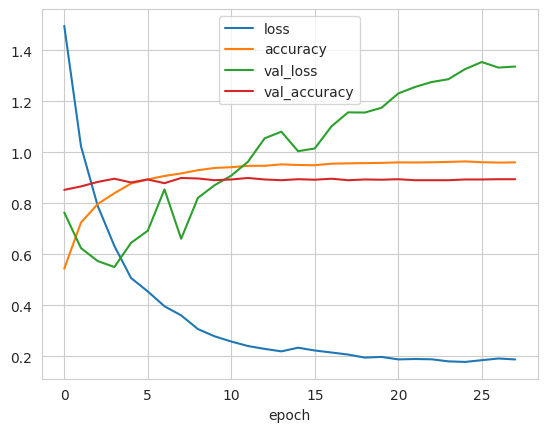

In [17]:
history.plot()

In [18]:
result = model.predict(test_ids)


33/33 [==============================] - 20s 433ms/step


In [19]:
result = result > .5
y_pred = result.astype(int)
y_true = test_labels

In [20]:
l = list(label_binarizer.classes_)

In [21]:

conf = multilabel_confusion_matrix(y_true, y_pred)

conf

array([[[955,   6],
        [  9,  58]],

       [[915,  11],
        [ 18,  84]],

       [[861,  16],
        [ 25, 126]],

       [[969,   5],
        [  7,  47]],

       [[827,  33],
        [ 23, 145]],

       [[907,   1],
        [  0, 120]],

       [[853,   7],
        [  7, 161]],

       [[868,  19],
        [ 16, 125]],

       [[961,  10],
        [  5,  52]]])

In [22]:
"""
f1_score(y_true, y_pred, average='macro')
f1_score(y_true, y_pred, average='micro')
f1_score(y_true, y_pred, average='weighted')
"""
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score ,precision_score, make_scorer, recall_score

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred,average='macro')
roc_auc = roc_auc_score(y_true, y_pred)
prec = precision_score(y_true, y_pred,average='macro')
rec = recall_score(y_true, y_pred,average='macro')
print('Accuracy:', acc)
print('F1-Score:', f1)
print('ROC-AUC:', roc_auc)
print('Recall:', rec)
print('Precision:', prec)

Accuracy: 0.8929961089494164
F1-Score: 0.8920695089599929
ROC-AUC: 0.9385228025936113
Recall: 0.8904714006552032
Precision: 0.8947857187661418


In [23]:
"""
import pickle
from google.colab import drive
drive.mount('/content/drive')

x= {'model' : model, 'result_test' : result, 'LabelBinarizer' : LabelBinarizer};
output = open('/content/drive/MyDrive/Colab Notebooks/model.pkl', 'wb')
pickle.dump(x,output)
"""

"\nimport pickle\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nx= {'model' : model, 'result_test' : result, 'LabelBinarizer' : LabelBinarizer};\noutput = open('/content/drive/MyDrive/Colab Notebooks/model.pkl', 'wb')\npickle.dump(x,output)\n"